In [1]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, to_date, when, concat, lit
from pyspark.sql.types import TimestampType
import matplotlib.pyplot as plt
import numpy as np

spark = SparkSession.builder \
    .appName("green preprocessing") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .config("spark.sql.parquet.cacheMetadata", "true") \
    .config("spark.sql.session.timeZone", "Etc/UTC") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

your 131072x1 screen size is bogus. expect trouble
23/09/07 17:14:41 WARN Utils: Your hostname, NivethanAsus resolves to a loopback address: 127.0.1.1; using 172.24.42.146 instead (on interface eth0)
23/09/07 17:14:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/07 17:14:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
path1 = "../../data/curated/all_data_combined.parquet"
df = spark.read.parquet(path1)
df.show(5)
df.count()
df.printSchema()


23/09/07 17:15:05 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------------+------------+--------------+-------+-----------+-------------+--------------+---------------+------------------+----------------------------+--------------------+--------------------+----------------------+--------------------+----------------------------+-----------------+--------------------+-----------------+-----------------+--------------+--------------+---------------------------------+-------------------------------+----------------------+-----------------------------+--------------------------------+-----------------------------+--------------------------+
|consumer_postcode|merchant_abn|order_datetime|user_id|consumer_id|consumer_name|consumer_state|consumer_gender|      dollar_value|consumer_fraud_probability_%|       merchant_name|merchant_description|merchant_revenue_level|merchant_take_rate_%|merchant_fraud_probability_%|consumer_sa2_code|   consumer_sa4_name|consumer_sa3_name|consumer_sa2_name|sa2_population|sa2_median_age|sa2_median_mortgage_repay_mont

In [3]:
# Grouping by the merchant_abn and counting the number of transactions for each merchant
from pyspark.sql import functions as F

# Aggregating to get both transaction count and total dollar value for each merchant
merchant_transaction = df.groupBy("merchant_abn").agg(
    F.count("order_datetime").alias("transaction_count"),
    F.sum("dollar_value").alias("total_sales")
)

# Converting the result to a list
merchant_transaction_list = merchant_transaction.collect()
merchant_transaction_list

[Row(merchant_abn=41956465747, transaction_count=447, total_sales=101536.07299892615),
 Row(merchant_abn=83412691377, transaction_count=21889, total_sales=759916.9225384021),
 Row(merchant_abn=96946925998, transaction_count=173, total_sales=174386.60492781634),
 Row(merchant_abn=73256306726, transaction_count=8031, total_sales=2293839.2050764556),
 Row(merchant_abn=38700038932, transaction_count=11253, total_sales=15074203.01079477),
 Row(merchant_abn=35344855546, transaction_count=2269, total_sales=196968.92585550045),
 Row(merchant_abn=78916025936, transaction_count=86, total_sales=28186.948760531435),
 Row(merchant_abn=15613631617, transaction_count=2743, total_sales=825895.9979906013),
 Row(merchant_abn=73841664453, transaction_count=1557, total_sales=131704.4716365512),
 Row(merchant_abn=92202115241, transaction_count=160, total_sales=50973.09034637582),
 Row(merchant_abn=48214071373, transaction_count=844, total_sales=249182.14268304786),
 Row(merchant_abn=19839532017, transactio

In [4]:
# Sorting the data by transaction count
sorted_transaction_list = sorted(merchant_transaction_list, key=lambda x: x.transaction_count)
num_unique_merchants = len(merchant_transaction_list)

# Average number of transactions
avg_transactions = sum([row.transaction_count for row in merchant_transaction_list]) / num_unique_merchants
# Minimum number of transactions
min_transactions = min([row.transaction_count for row in merchant_transaction_list])
# Maximum number of transactions
max_transactions = max([row.transaction_count for row in merchant_transaction_list])
# Quantiles (25th, 50th, and 75th percentiles)
transaction_counts = [row.transaction_count for row in merchant_transaction_list]

transaction_counts.sort()
q25 = transaction_counts[num_unique_merchants // 4]
q50 = transaction_counts[num_unique_merchants // 2]
q75 = transaction_counts[3 * num_unique_merchants // 4]
transaction_stats = {
    "Number of Unique Merchants": num_unique_merchants,
    "Average Transactions": avg_transactions,
    "Minimum Transactions": min_transactions,
    "Maximum Transactions": max_transactions,
    "25th Percentile": q25,
    "Median (50th Percentile)": q50,
    "75th Percentile": q75
}

transaction_stats


{'Number of Unique Merchants': 4026,
 'Average Transactions': 5206.861400894188,
 'Minimum Transactions': 1,
 'Maximum Transactions': 444597,
 '25th Percentile': 140,
 'Median (50th Percentile)': 645,
 '75th Percentile': 3167}

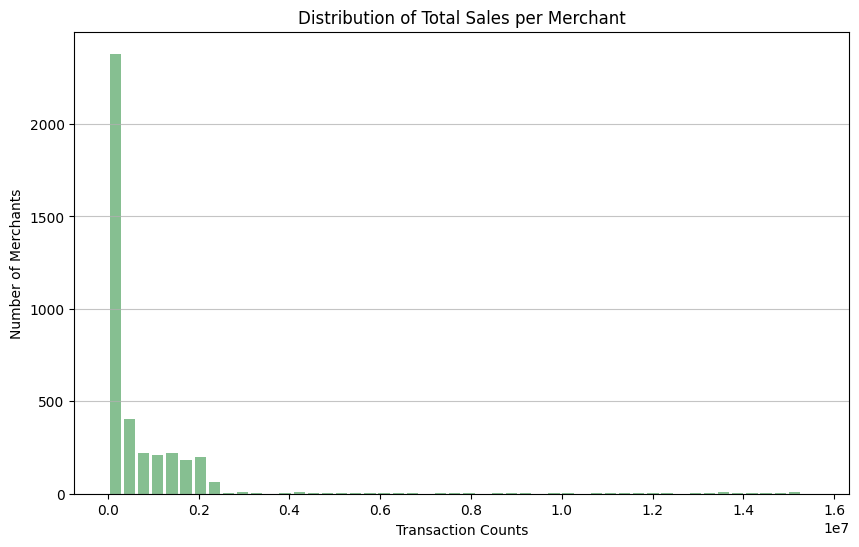

{'Number of Unique Merchants': 4026,
 'Average Sales': 824521.7878280542,
 'Minimum Sales': 7677.628516018768,
 'Maximum Sales': 15592652.574618042,
 '25th Percentile': 55404.44707820839,
 'Median (50th Percentile)': 216611.22025806218,
 '75th Percentile': 977569.4239187131}

In [5]:
total_sales_values = [row['total_sales'] for row in merchant_transaction_list]

# transaction Statistics
total_sales_transaction = {
    'Number of Unique Merchants': len(set(total_sales_values)),
    'Average Sales': sum(total_sales_values) / len(total_sales_values),
    'Minimum Sales': min(total_sales_values),
    'Maximum Sales': max(total_sales_values),
    '25th Percentile': np.percentile(total_sales_values, 25),
    'Median (50th Percentile)': np.percentile(total_sales_values, 50),
    '75th Percentile': np.percentile(total_sales_values, 75)
}

# Plotting the histogram
plt.figure(figsize=(10,6))
plt.hist(total_sales_values, bins=50, color='#86bf91', rwidth=0.8)
plt.title('Distribution of Total Sales per Merchant')
plt.xlabel('Transaction Counts')
plt.ylabel('Number of Merchants')
plt.grid(axis='y', alpha=0.75)
plt.show()


total_sales_transaction

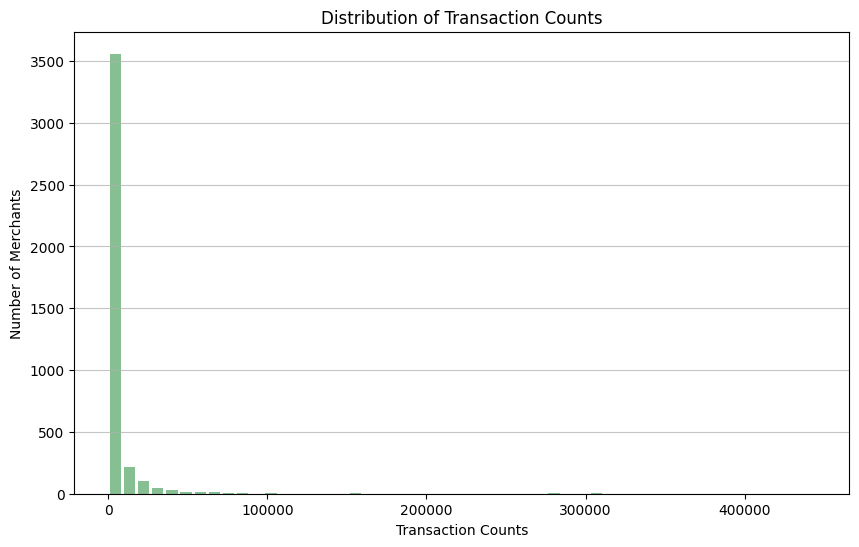

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting transaction counts for histogram
transaction_counts = [row['transaction_count'] for row in merchant_transaction_list]

plt.figure(figsize=(10,6))
plt.hist(transaction_counts, bins=50, color='#86bf91', rwidth=0.8)
plt.title('Distribution of Transaction Counts')
plt.xlabel('Transaction Counts')
plt.ylabel('Number of Merchants')
plt.grid(axis='y', alpha=0.75)
plt.show()





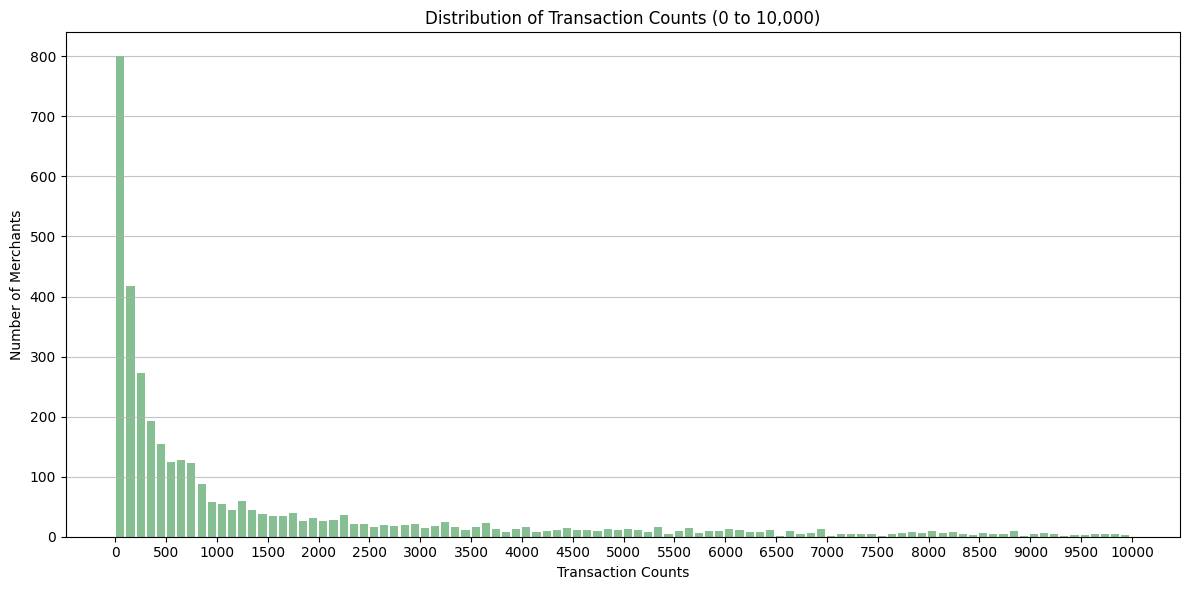

In [7]:
# Filtering transaction counts to values between 0 and 10000
filtered_transaction_counts = [count for count in transaction_counts if 0 <= count <= 10000]

plt.figure(figsize=(12,6))
plt.hist(filtered_transaction_counts, bins=100, color='#86bf91', rwidth=0.8)
plt.title('Distribution of Transaction Counts (0 to 10,000)')
plt.xlabel('Transaction Counts')
plt.ylabel('Number of Merchants')
plt.xticks(np.arange(0, 10001, 500))
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()


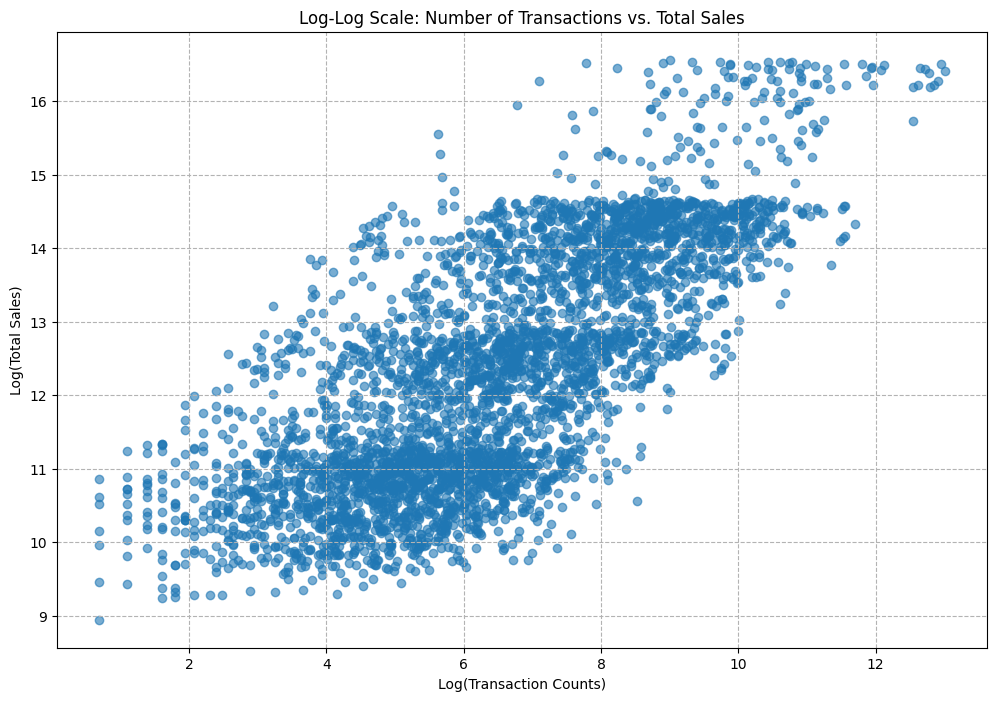

23/09/08 00:40:32 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1718610 ms exceeds timeout 120000 ms
23/09/08 00:40:32 WARN SparkContext: Killing executors is not supported by current scheduler.
23/09/08 00:40:33 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.

In [8]:
# Extracting transaction counts and total sales for scatter plot from the merchant_transaction_list
# Transforming data for log-log scale visualization
transaction_counts = [row['transaction_count'] for row in merchant_transaction_list]
total_sales= [row['total_sales'] for row in merchant_transaction_list]
log_transaction_counts = [np.log1p(tc) for tc in transaction_counts]
log_total_sales = [np.log1p(sales) for sales in total_sales]

plt.figure(figsize=(12, 8))
plt.scatter(log_transaction_counts, log_total_sales, alpha=0.6)
plt.title('Log-Log Scale: Number of Transactions vs. Total Sales')
plt.xlabel('Log(Transaction Counts)')
plt.ylabel('Log(Total Sales)')
plt.grid(True, which="both", ls="--", c='0.7')
plt.show()

